In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.gridspec as gridspec
import numpy as np

from PIL import Image
import urllib
import json
import os

In [15]:
plt.style.use("./assets/stylesheets/soc_base.mplstyle")

In [16]:
df2021 = pd.read_csv('data/seriea_xg_2021.csv', index_col=0)
df2122 = pd.read_csv('data/seriea_xg_2122.csv', index_col=0)
df2223 = pd.read_csv('data/seriea_xg_2223.csv', index_col=0)
df=pd.concat([df2021,df2122,df2223]).reset_index(drop=True)
df = df.sort_values(by='date').reset_index(drop=True)

team_id = 8524
color_1 = '#DBA111'
color_2 = '#da020e'

teams_color = pd.read_csv('data/serie_a_teams.csv',index_col=0)
color_1 = teams_color[teams_color['team_id']==team_id].iloc[0]['color1']
color_2 = teams_color[teams_color['team_id']==team_id].iloc[0]['color2']


In [17]:
# xg rolling data
df_xg = df[(df['team_id'] == team_id) & (
    df['variable'].isin(['xG_for', 'xG_ag']))]

df_xg1 = (df_xg.pivot(
    index=['date', 'match_id', 'team_id', 'team_name'],
    columns=['variable'],
    values=['value']
)
    .reset_index()
    .droplevel(level=0, axis=1))

df_xg1.columns = ['date','match_id','team_id','team_name','xG_ag','xG_for']
df_xg1['rolling_xG_for'] = df_xg1['xG_for'].rolling(window=10, min_periods=0).mean()
df_xg1['rolling_xG_ag'] = df_xg1['xG_ag'].rolling(window=10, min_periods=0).mean()
df_xg1['rolling_diff'] = df_xg1['rolling_xG_for'] - df_xg1['rolling_xG_ag']

In [18]:
# xg interpolated
df_xg1['match_number'] = df_xg1.index

X_aux = df_xg1.match_number.copy()
X_aux.index = X_aux * 10
last_idx = X_aux.index[-1]+1
X_aux = X_aux.reindex(range(last_idx))
X_aux = X_aux.interpolate()

Y_for_aux = df_xg1.rolling_xG_for.copy()
Y_for_aux.index = Y_for_aux.index*10
last_idx = Y_for_aux.index[-1]+1
Y_for_aux = Y_for_aux.reindex(range(last_idx))
Y_for_aux = Y_for_aux.interpolate()

Y_ag_aux = df_xg1.rolling_xG_ag.copy()
Y_ag_aux.index = Y_ag_aux.index*10
last_idx = Y_ag_aux.index[-1]+1
Y_ag_aux = Y_ag_aux.reindex(range(last_idx))
Y_ag_aux = Y_ag_aux.interpolate()

Z_diff_aux = df_xg1.rolling_diff.copy()
Z_diff_aux.index = Z_diff_aux.index*10
last_idx = Z_diff_aux.index[-1]+1
Z_diff_aux = Z_diff_aux.reindex(range(last_idx))
Z_diff_aux = Z_diff_aux.interpolate()

df_aux = pd.DataFrame({
    'X': X_aux,
    'Y_for': Y_for_aux,
    'Y_ag': Y_ag_aux,
    'Z':Z_diff_aux
})


In [19]:
def colorFader(c1, c2, mix=0):
    c1 = np.array(mcolors.to_rgb(c1))
    c2 = np.array(mcolors.to_rgb(c2))
    return mcolors.to_hex((1-mix)*c1 + mix*c2)

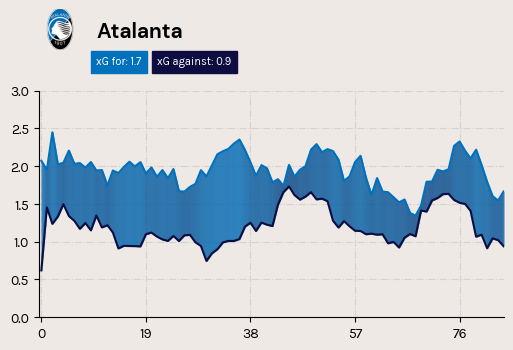

In [20]:
fig = plt.figure(figsize=(6,4), dpi=100)
nrows = 2
ncols = 1
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1/nrows)*2.35 if x % 2 != 0 else (1/nrows)/2.35 for x in range(nrows)], hspace=.3
)
ax2 = plt.subplot(gspec[1,0])
ax1 = plt.subplot(gspec[0,0],anchor='NW')

df_xg = df_xg1.copy()
df_aux_xg = df_aux

ax2.set_ylim(0, 3)
ax2.set_xlim(-0.5, df_xg.shape[0]-1)
ax2.grid(ls='-.', color='lightgrey')

ax2.plot(df_xg.index, df_xg['rolling_xG_for'], color=color_2, zorder=4)
ax2.plot(df_xg.index, df_xg['rolling_xG_ag'], color=color_1, zorder=4)
vmin = df_xg['rolling_diff'].min()
vmax = df_xg['rolling_diff'].max()
vmax = max(abs(vmin), abs(vmax))
vmin = -1*vmax

for i in range(0, len(df_aux_xg['X'])-1):
    ax2.fill_between(
        [df_aux_xg['X'].iloc[i], df_aux_xg['X'].iloc[i+1]],
        [df_aux_xg['Y_for'].iloc[i], df_aux_xg['Y_for'].iloc[i+1]],
        [df_aux_xg['Y_ag'].iloc[i], df_aux_xg['Y_ag'].iloc[i+1]],
        color=colorFader(color_1, color_2, mix=(
            df_aux_xg['Z'].iloc[i]-vmin)/(vmax-vmin)),
        zorder=3,
        alpha=.3
    )

ax2.xaxis.set_major_locator(ticker.MultipleLocator(19))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(.5))

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
teamName = df_xg['team_name'].iloc[0]
xG_for = df_xg['rolling_xG_for'].iloc[-1]
xG_ag = df_xg['rolling_xG_ag'].iloc[-1]
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))
ax1.imshow(club_icon)
ax1.axis('off')

ax_text(
    x=1.4,
    y=.7,
    s=f'<{teamName}>\n<xG for: {xG_for:.1f}> <|> <xG against: {xG_ag:.1f}>',
    ax=ax1,
    highlight_textprops=[
        {'weight':'bold','font':'DM Sans'},
        {'size':'8', 'bbox': {'edgecolor':color_2,'facecolor':color_2},'color':'white'},
        {'color':'#EFE9E6'},
        {'size':'8', 'bbox': {'edgecolor':color_1,'facecolor':color_1},'color':'white'},
    ],
    font = 'Karla',
    ha='left',
    size=15,
    annotationbbox_kw={'xycoords':'axes fraction'}
)
